In [1]:
import sys
sys.path.append("../../../")

from smc.sampler import SMCsampler
from smc.prior import M71Prior
from smc.images import M71ImageModel
from smc.kernel import SingleComponentMH
from smc.aggregate import Aggregate

import torch

import matplotlib.pyplot as plt

import numpy as np

import pickle

from utils.misc import select_cuda_device

device = select_cuda_device()
torch.cuda.set_device(device)
torch.set_default_device(device)

Selected device 4, which has 10820 MB available.


### Generate one image

In [ ]:
with open('../../m71/manyimages/data/params.pkl', 'rb') as f:
    params = pickle.load(f)

params

{'flux_alpha': 0.21411753249015655,
 'flux_lower': 0.25165176391601557,
 'flux_upper': 1804.6791992187502,
 'counts_rate': 1.9369369745254517,
 'background': 104.1486587524414,
 'adu_per_nmgy': 240.57542419433594,
 'psf_params': tensor([1.2269, 2.6466, 5.6672, 7.0683, 0.4634, 0.0884]),
 'noise_additive': 7.312718763863302e-10,
 'noise_multiplicative': 1.939667820930481}

In [3]:
torch.manual_seed(0)
np.random.seed(0)

image_dim = 16

background = params["background"]
adu_per_nmgy = params["adu_per_nmgy"]
psf_params = params["psf_params"]
noise_additive = params["noise_additive"]
noise_multiplicative = params["noise_multiplicative"]

pad = 1

TruePrior = M71Prior(max_objects = 100,
                     counts_rate = (params["counts_rate"] / 64) * ((image_dim + 2*pad)**2),
                     image_height = image_dim,
                     image_width = image_dim,
                     flux_alpha = params["flux_alpha"],
                     flux_lower = params["flux_lower"],
                     flux_upper = params["flux_upper"],
                     pad = pad)

TrueImageModel = M71ImageModel(image_height = image_dim,
                               image_width = image_dim,
                               background = background,
                               adu_per_nmgy = adu_per_nmgy,
                               psf_params = psf_params,
                               noise_additive = noise_additive,
                               noise_multiplicative = noise_multiplicative)

(unpruned_counts, unpruned_locs, unpruned_fluxes,
 pruned_counts, pruned_locs, pruned_fluxes, images) = TrueImageModel.generate(Prior = TruePrior,
                                                                              num_images = 100)

image = images[20].squeeze()

### Plot attributes

In [4]:
image_dim = images.shape[1]

grid_interval = image_dim // 2
pad = 1

cmap = 'gray'
linewidth = 6
linestyle = 'dashed'
pad_color1 = 'mediumblue'
pad_color2 = 'gold'
pad_color3 = 'red'
pad_color4 = 'forestgreen'

### Image

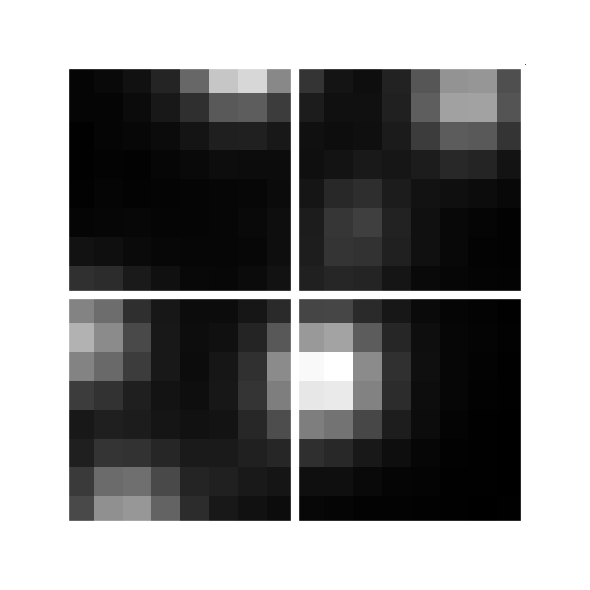

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (6,6))
img = ax.imshow(image.cpu().squeeze(), cmap = cmap)
_ = ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
_ = ax.set_xticks([])
_ = ax.set_yticks([])

# tile borders
_ = ax.vlines(x = [c * grid_interval - 0.5 for c in [0,1,2]],
              ymin = 0 * grid_interval - 0.5, ymax = 2 * grid_interval - 0.5,
              color = 'white', linewidth = linewidth)
_ = ax.hlines(y = [c * grid_interval - 0.5 for c in [0,1,2]],
              xmin = 0 * grid_interval - 0.5, xmax = 2 * grid_interval - 0.5,
              color = 'white', linewidth = linewidth)

# transparent padding (for image size consistency)
_ = ax.vlines(x = [0 * grid_interval - pad - 0.5, 2 * grid_interval + pad - 0.5],
              ymin = 0 * grid_interval - pad - 0.5, ymax = 2 * grid_interval + pad - 0.5,
              color = pad_color1, linestyles = linestyle, linewidth = linewidth, alpha = 0)
_ = ax.hlines(y = [0 * grid_interval - pad - 0.5, 2 * grid_interval + pad - 0.5],
              xmin = 0 * grid_interval - pad - 0.5, xmax = 2 * grid_interval + pad - 0.5,
              color = pad_color1, linestyles = linestyle, linewidth = linewidth, alpha = 0)

fig.tight_layout()

fig.savefig('results/figures/divideandconquer_image.png', dpi = 250, transparent = True, bbox_inches = 'tight', pad_inches = 0)

### Four quadrants

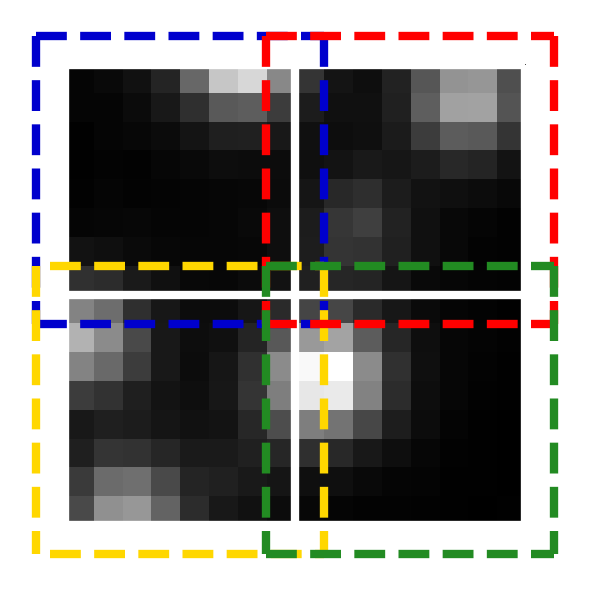

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (6,6))
img = ax.imshow(image.cpu().squeeze(), cmap = cmap)
_ = ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
_ = ax.set_xticks([])
_ = ax.set_yticks([])

# tile borders
_ = ax.vlines(x = [c * grid_interval - 0.5 for c in [0,1,2]],
              ymin = 0 * grid_interval - 0.5, ymax = 2 * grid_interval - 0.5,
              color = 'white', linewidth = linewidth)
_ = ax.hlines(y = [c * grid_interval - 0.5 for c in [0,1,2]],
              xmin = 0 * grid_interval - 0.5, xmax = 2 * grid_interval - 0.5,
              color = 'white', linewidth = linewidth)

# quadrant 1
_ = ax.vlines(x = [0 * grid_interval - pad - 0.5, 1 * grid_interval + pad - 0.5],
              ymin = 0 * grid_interval - pad - 0.5, ymax = 1 * grid_interval + pad - 0.5,
              color = pad_color1, linestyles = linestyle, linewidth = linewidth)
_ = ax.hlines(y = [0 * grid_interval - pad - 0.5, 1 * grid_interval + pad - 0.5],
              xmin = 0 * grid_interval - pad - 0.5, xmax = 1 * grid_interval + pad - 0.5,
              color = pad_color1, linestyles = linestyle, linewidth = linewidth)

# quadrant 2
_ = ax.vlines(x = [0 * grid_interval - pad - 0.5, 1 * grid_interval + pad - 0.5],
              ymin = 1 * grid_interval - pad - 0.5, ymax = 2 * grid_interval + pad - 0.5,
              color = pad_color2, linestyles = linestyle, linewidth = linewidth)
_ = ax.hlines(y = [1 * grid_interval - pad - 0.5, 2 * grid_interval + pad - 0.5],
              xmin = 0 * grid_interval - pad, xmax = 1 * grid_interval + pad - 0.5,
              color = pad_color2, linestyles = linestyle, linewidth = linewidth)

# quadrant 3
_ = ax.vlines(x = [1 * grid_interval - pad - 0.5, 2 * grid_interval + pad - 0.5],
              ymin = 0 * grid_interval - pad - 0.5, ymax = 1 * grid_interval + pad - 0.5,
              color = pad_color3, linestyles = linestyle, linewidth = linewidth)
_ = ax.hlines(y = [0 * grid_interval - pad - 0.5, 1 * grid_interval + pad - 0.5],
              xmin = 1 * grid_interval - pad - 0.5, xmax = 2 * grid_interval + pad - 0.5,
              color = pad_color3, linestyles = linestyle, linewidth = linewidth)

# quadrant 4
_ = ax.vlines(x = [1 * grid_interval - pad - 0.5, 2 * grid_interval + pad - 0.5],
              ymin = 1 * grid_interval - pad - 0.5, ymax = 2 * grid_interval + pad - 0.5,
              color = pad_color4, linestyles = linestyle, linewidth = linewidth)
_ = ax.hlines(y = [1 * grid_interval - pad - 0.5, 2 * grid_interval + pad - 0.5],
              xmin = 1 * grid_interval - pad - 0.5, xmax = 2 * grid_interval + pad - 0.5,
              color = pad_color4, linestyles = linestyle, linewidth = linewidth)

fig.tight_layout()

fig.savefig('results/figures/divideandconquer_quadrants.png', dpi = 250, transparent = True, bbox_inches = 'tight', pad_inches = 0)

### Two halves

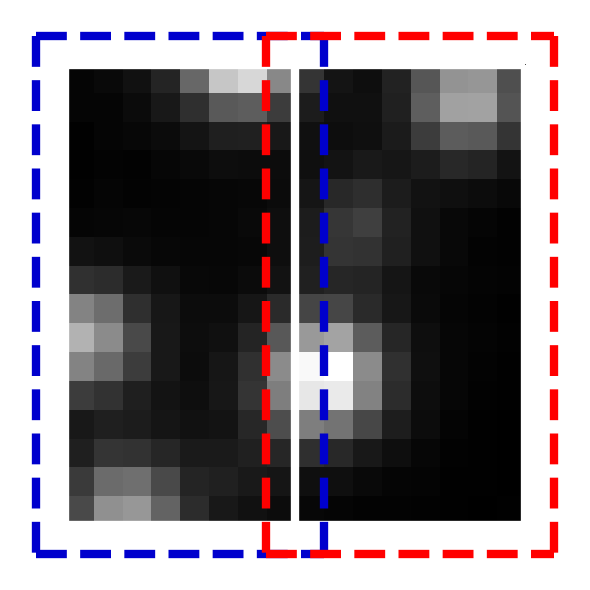

In [7]:
fig, ax = plt.subplots(1, 1, figsize = (6,6))
img = ax.imshow(image.cpu().squeeze(), cmap = cmap)
_ = ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
_ = ax.set_xticks([])
_ = ax.set_yticks([])

# tile borders
_ = ax.vlines(x = [c * grid_interval - 0.5 for c in [0,1,2]],
              ymin = 0 * grid_interval - 0.5, ymax = 2 * grid_interval - 0.5,
              color = 'white', linewidth = linewidth)
_ = ax.hlines(y = [c * grid_interval - 0.5 for c in [0,2]],
              xmin = 0 * grid_interval - 0.5, xmax = 2 * grid_interval - 0.5,
              color = 'white', linewidth = linewidth)

# half 1
_ = ax.vlines(x = [0 * grid_interval - pad - 0.5, 1 * grid_interval + pad - 0.5],
              ymin = 0 * grid_interval - pad - 0.5, ymax = 2 * grid_interval + pad - 0.5,
              color = pad_color1, linestyles = linestyle, linewidth = linewidth)
_ = ax.hlines(y = [0 * grid_interval - pad - 0.5, 2 * grid_interval + pad - 0.5],
              xmin = 0 * grid_interval - pad - 0.5, xmax = 1 * grid_interval + pad - 0.5,
              color = pad_color1, linestyles = linestyle, linewidth = linewidth)

# half 2
_ = ax.vlines(x = [1 * grid_interval - pad - 0.5, 2 * grid_interval + pad - 0.5],
              ymin = 0 * grid_interval - pad - 0.5, ymax = 2 * grid_interval + pad - 0.5,
              color = pad_color3, linestyles = linestyle, linewidth = linewidth)
_ = ax.hlines(y = [0 * grid_interval - pad - 0.5, 2 * grid_interval + pad - 0.5],
              xmin = 1 * grid_interval - pad - 0.5, xmax = 2 * grid_interval + pad - 0.5,
              color = pad_color3, linestyles = linestyle, linewidth = linewidth)

fig.tight_layout()

fig.savefig('results/figures/divideandconquer_halves.png', dpi = 250, transparent = True, bbox_inches = 'tight', pad_inches = 0)

### One whole

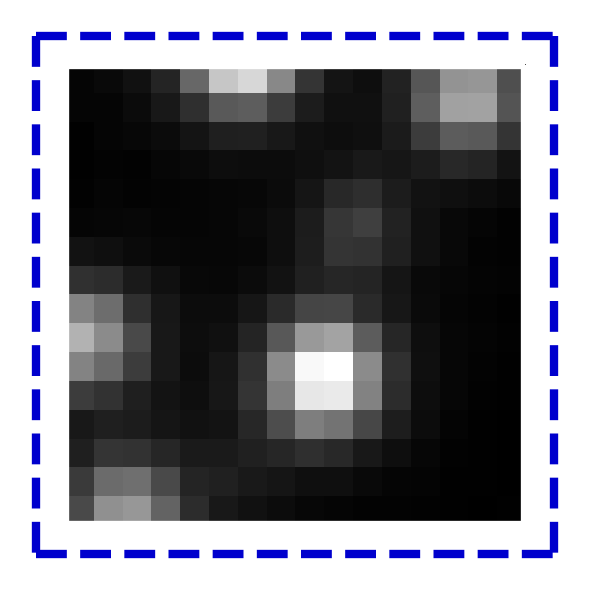

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (6,6))
img = ax.imshow(image.cpu().squeeze(), cmap = cmap)
_ = ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
_ = ax.set_xticks([])
_ = ax.set_yticks([])

# tile borders
_ = ax.vlines(x = [c * grid_interval - 0.5 for c in [0,2]],
              ymin = 0 * grid_interval - 0.5, ymax = 2 * grid_interval - 0.5,
              color = 'white', linewidth = linewidth)
_ = ax.hlines(y = [c * grid_interval - 0.5 for c in [0,2]],
              xmin = 0 * grid_interval - 0.5, xmax = 2 * grid_interval - 0.5,
              color = 'white', linewidth = linewidth)

# image (with padding)
_ = ax.vlines(x = [0 * grid_interval - pad - 0.5, 2 * grid_interval + pad - 0.5],
              ymin = 0 * grid_interval - pad - 0.5, ymax = 2 * grid_interval + pad - 0.5,
              color = pad_color1, linestyles = linestyle, linewidth = linewidth)
_ = ax.hlines(y = [0 * grid_interval - pad - 0.5, 2 * grid_interval + pad - 0.5],
              xmin = 0 * grid_interval - pad - 0.5, xmax = 2 * grid_interval + pad - 0.5,
              color = pad_color1, linestyles = linestyle, linewidth = linewidth)

fig.tight_layout()

fig.savefig('results/figures/divideandconquer_whole.png', dpi = 250, transparent = True, bbox_inches = 'tight', pad_inches = 0)